# Introduction à Unets
L'architecture Unet est un réseau de neurones initialement développé pour la segmentation d'images biomédicales à l'Université de Freiburg, en Allemagne.
L'Unet est une sorte d'autoencodeur mais avec des connections résiduelles entre l'encodeur et le décodeur afin d'éviter la disparition du gradient et de connecter les informations extraites par l'encodeur au décodeur plus facilement. Ces connections permettent au réseasu de capturer et de propager efficacement les informations de contexte.

![Unet architecture](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/image-hosting/TP4_Unet/u-net-architecture.png)


L'Unet est composée d'une structure encodeur-décodeur avec des connexions de saut (skip connections), lui permettant de capturer à la fois des features de haut et bas niveau.

L'architecture Unet en détail:

Encodeur : L'encodeur est responsable de l'extraction des features de l'image en entrée. Il consiste de plusieurs blocs de couche de convolution et un maxpooling entre chaque bloc pour réduire la taille de l'image.

Bridge: Le bridge sert à connecter les features extraits par l'encodeur à chaque niveau à l'entrée du décodeur, en concatenant la sortie de chaque bloc de l'encodeur à la sortie du bloc correspondant du décodeur.

Décodeur : Le décodeur s'occupe de la tâche essentielle de remapper les features de haut niveau extraites par l'encodeur en une image de sortie reconstruite. Il est composé également de plusieurs blocs, et utilise des couches de convolution transposées pour effectuer l'upsampling des features, rétablissant ainsi leurs dimensions originales. Chaque bloc du décodeur reçoit non seulement les données upsampled du bloc précédent, mais aussi les données de l'encodeur correspondant grâce aux connexions de saut. Ces données concaténées sont ensuite transmises à travers des couches de convolution pour affiner les features upsampled.


## Debruitage des images

On va essayer d'améliorer notre modèle de débruitage d'images qu'on a fait en TP3 en utilisant l'architecture UNet.

## Importation des librairies et téléchargements de MNIST

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data
X_test = test_dataset.data

print(X_train.shape)
print(X_test.shape)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 352kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Exercice 1: Normalisation des images et ajout de bruit
Normaliser les images en [0, 1] et ajouter du bruit sur les images de train et de test.

In [ ]:
import torch
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

X_train_noise = X_train_normalized + torch.randn_like(X_train_normalized) * 1
X_test_noise = X_test_normalized + torch.randn_like(X_test_normalized) * 1

print(X_train_noise.shape)
print(X_test_noise.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Exercice 2: Visualisation des données bruitées

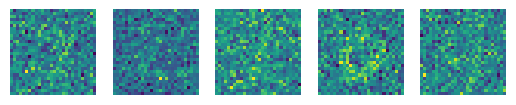

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_test_noise[i])
  plt.axis('off')

## Exercice 3: Création du modèle


### Encodeur
Voici le schéma de l'encodeur qu'on va créer (avec des ReLU après chaque couche de convolution):


In [ ]:
# Layer (type)                   Output Shape
# ================================================================
# input_1               (1, 28, 28)
# ________________________________________________________________
# conv2d_1              (32, 28, 28)
# ________________________________________________________________
# maxpooling2d_1        (32, 14, 14)
# ________________________________________________________________
# conv2d_2              (64, 14, 14)
# ________________________________________________________________
# maxpooling2d_2        (64, 7, 7)
# ________________________________________________________________
# conv2d_3 (Conv2D)     (128, 7, 7)
# ________________________________________________________________
# maxpooling2d_3        (128, 3, 3)
# ________________________________________________________________
# conv2d_4              (256, 3, 3)
# ________________________________________________________________
# maxpooling2d_4        (256, 1, 1)
# ________________________________________________________________
# conv2d_5              (256, 1, 1)
# ________________________________________________________________
# outputs               [(32, 28, 28), (64, 14, 14), (128, 7, 7), (256, 3, 3), (256, 1, 1)]

Il faut retourner non seulement la sortie de conv2d_5 mais aussi les sorties de conv2d_1, conv2d_2, conv2d_3 et conv2d_4 pour les utiliser dans le décodeur.
Vous pouvez par exemple mettre les sorties dans une liste et les retourner.

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
	def __init__(self):
		super().__init__()
		self.relu = nn.ReLU()

		self.conv2d_1 = nn.Conv2d(1, 32, kernel_size = 3, padding = "same")
		self.conv2d_2 = nn.Conv2d(32, 64, kernel_size = 3, padding = "same")
		self.conv2d_3 = nn.Conv2d(64, 128, kernel_size = 3, padding = "same")
		self.conv2d_4 = nn.Conv2d(128, 256, kernel_size = 3, padding = "same")
		self.conv2d_5 = nn.Conv2d(256, 256, kernel_size = 3, padding = "same")

		self.maxpooling2d_1 = nn.MaxPool2d(kernel_size = 2)
		self.maxpooling2d_2 = nn.MaxPool2d(kernel_size = 2)
		self.maxpooling2d_3 = nn.MaxPool2d(kernel_size = 2)
		self.maxpooling2d_4 = nn.MaxPool2d(kernel_size = 2)

	def forward(self, x):
		x = self.conv2d_1(x)
		x = self.relu(x)
		res1 = x
		x = self.maxpooling2d_1(x)

		x = self.conv2d_2(x)
		x = self.relu(x)
		res2 = x
		x = self.maxpooling2d_2(x)

		x = self.conv2d_3(x)
		x = self.relu(x)
		res3 = x
		x = self.maxpooling2d_3(x)

		x = self.conv2d_4(x)
		x = self.relu(x)
		res4 = x
		x = self.maxpooling2d_4(x)

		x = self.conv2d_5(x)
		x = self.relu(x)
		res5 = x

		return [res1, res2, res3, res4, res5]

### Torchinfo pour vérifier

In [ ]:
!pip install torchinfo
from torchinfo import summary

batch_size = 5
encoder = Encoder()
summary(encoder, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [5, 32, 28, 28]           --
├─Conv2d: 1-1                            [5, 32, 28, 28]           320
├─ReLU: 1-2                              [5, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [5, 32, 14, 14]           --
├─Conv2d: 1-4                            [5, 64, 14, 14]           18,496
├─ReLU: 1-5                              [5, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [5, 64, 7, 7]             --
├─Conv2d: 1-7                            [5, 128, 7, 7]            73,856
├─ReLU: 1-8                              [5, 128, 7, 7]            --
├─MaxPool2d: 1-9                         [5, 128, 3, 3]            --
├─Conv2d: 1-10                           [5, 256, 3, 3]            295,168
├─ReLU: 1-11                             [5, 256, 3, 3]            --
├─MaxPool2d: 1-12                        [5, 256, 1, 1]            --
├

### Décodeur
Pour concatener, regarder la fonction torch.cat: https://pytorch.org/docs/stable/generated/torch.cat.html

Voici le schéma du décodeur qu'on va créer (avec des ReLU après chaque couche de convolution):

In [ ]:
# Layer (type)                   Output Shape
# ================================================================
# input_1               [(32, 28, 28), (64, 14, 14), (128, 7, 7), (256, 3, 3), (256, 1, 1)]
# ________________________________________________________________
# conv2d_transpose_1    (256, 3, 3)
# ________________________________________________________________
# concatenate_1         (512, 3, 3)
# ________________________________________________________________
# conv2d_6              (256, 3, 3)
# ________________________________________________________________
# conv2d_transpose_2    (128, 7, 7)
# ________________________________________________________________
# concatenate_2         (256, 7, 7)
# ________________________________________________________________
# conv2d_7              (128, 7, 7)
# ________________________________________________________________
# conv2d_transpose_3    (64, 14, 14)
# ________________________________________________________________
# concatenate_3         (128, 14, 14)
# ________________________________________________________________
# conv2d_8              (64, 14, 14)
# ________________________________________________________________
# conv2d_transpose_4    (32, 28, 28)
# ________________________________________________________________
# concatenate_4         (64, 28, 28)
# ________________________________________________________________
# conv2d_9              (1, 28, 28)
# ________________________________________________________________


Compléter la classe Decoder ci-dessous. `encoder_outputs` est une liste qui contient des `torch.Tensor`, correspondant aux sorties des couches de convolution de l'encodeur.

In [ ]:
class Decoder(nn.Module):
	def __init__(self):
		super().__init__()
		self.relu = nn.ReLU()

		self.conv2d_transpose_1 = nn.ConvTranspose2d(256, 256, kernel_size = 3)
		self.conv2d_6 = nn.Conv2d(512, 256, kernel_size = 3, padding = "same")
		self.conv2d_transpose_2 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2)
		self.conv2d_7 = nn.Conv2d(256, 128, kernel_size = 3, padding = "same")
		self.conv2d_transpose_3 = nn.ConvTranspose2d(128, 64, kernel_size = 3, padding = 1, stride = 2, output_padding = 1)
		self.conv2d_8 = nn.Conv2d(128,64, kernel_size = 3, padding = "same")
		self.conv2d_transpose_4 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
		self.conv2d_9 = nn.Conv2d(64, 1, kernel_size = 3, padding = "same")

	def forward(self, *encoder_outputs):

		x = encoder_outputs[-1]
		x = self.conv2d_transpose_1(x)
		x = self.relu(x)
		x = torch.cat([x, encoder_outputs[-2]], dim = 1)
		x = self.conv2d_6(x)
		x = self.relu(x)

		x = self.conv2d_transpose_2(x)
		x = self.relu(x)
		x = torch.cat([x, encoder_outputs[-3]], dim = 1)
		x = self.conv2d_7(x)
		x = self.relu(x)

		x = self.conv2d_transpose_3(x)
		x = self.relu(x)
		x = torch.cat([x, encoder_outputs[-4]], dim = 1)
		x = self.conv2d_8(x)
		x = self.relu(x)

		x = self.conv2d_transpose_4(x)
		x = self.relu(x)
		x = torch.cat([x, encoder_outputs[-5]], dim = 1)
		x = self.conv2d_9(x)
		x = self.relu(x)

		return x

### Torchinfo pour vérifier

In [ ]:
from torchinfo import summary

batch_size = 5
decoder = Decoder()
summary(decoder, input_size=[(batch_size, 32, 28, 28), (batch_size, 64, 14, 14), (batch_size, 128, 7, 7), (batch_size, 256, 3, 3), (batch_size, 256, 1, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [5, 1, 28, 28]            --
├─ConvTranspose2d: 1-1                   [5, 256, 3, 3]            590,080
├─ReLU: 1-2                              [5, 256, 3, 3]            --
├─Conv2d: 1-3                            [5, 256, 3, 3]            1,179,904
├─ReLU: 1-4                              [5, 256, 3, 3]            --
├─ConvTranspose2d: 1-5                   [5, 128, 7, 7]            295,040
├─ReLU: 1-6                              [5, 128, 7, 7]            --
├─Conv2d: 1-7                            [5, 128, 7, 7]            295,040
├─ReLU: 1-8                              [5, 128, 7, 7]            --
├─ConvTranspose2d: 1-9                   [5, 64, 14, 14]           73,792
├─ReLU: 1-10                             [5, 64, 14, 14]           --
├─Conv2d: 1-11                           [5, 64, 14, 14]           73,792
├─ReLU: 1-12                             [5, 64, 14, 14

### Unet

In [ ]:
class Unet(nn.Module):
	def __init__(self):
		super().__init__()
		self.encoder = Encoder()
		self.decoder = Decoder()

	def forward(self, x):
		outs = self.encoder(x)
		out = self.decoder(*outs)
		return out

In [ ]:
batch_size = 5
unet = Unet()
summary(unet, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [5, 1, 28, 28]            --
├─Encoder: 1-1                           [5, 32, 28, 28]           --
│    └─Conv2d: 2-1                       [5, 32, 28, 28]           320
│    └─ReLU: 2-2                         [5, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [5, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [5, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [5, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [5, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [5, 128, 7, 7]            73,856
│    └─ReLU: 2-8                         [5, 128, 7, 7]            --
│    └─MaxPool2d: 2-9                    [5, 128, 3, 3]            --
│    └─Conv2d: 2-10                      [5, 256, 3, 3]            295,168
│    └─ReLU: 2-11                        [5, 256, 3, 3]            --
│

## Exercice 4: Entraînement du modèle (sur GPU) et visualisation des résultats

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [ ]:
#Regroupement des données en batch
batch_size = 20
width = X_train_normalized.shape[1]
height = X_train_normalized.shape[2]
X_train_reshaped_noise = X_train_noise.reshape(-1, batch_size, 1, width, height)
X_train_reshaped_clean = X_train_normalized.reshape(-1, batch_size, 1, width, height)

X_test_reshaped_noise = X_test_noise.reshape(-1, batch_size, 1, width, height)
X_test_reshaped_clean = X_test_normalized.reshape(-1, batch_size, 1, width, height)

print(X_train_noise.shape)
print(X_train.shape)

print(X_train_reshaped_noise.shape)
print(X_train_reshaped_clean.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([3000, 20, 1, 28, 28])
torch.Size([3000, 20, 1, 28, 28])


Epoch 0 -- Loss 0.02179604396224022


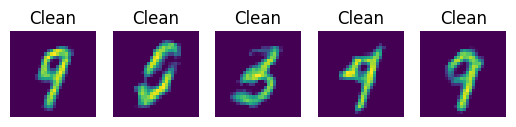

Epoch 10 -- Loss 0.01340681966394186


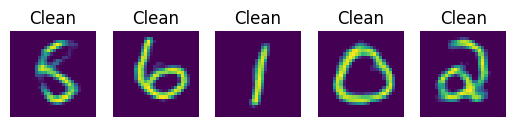

Epoch 20 -- Loss 0.010119594633579254


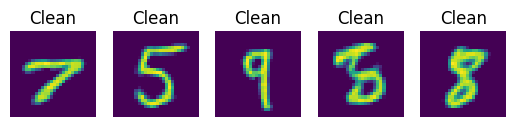

Epoch 30 -- Loss 0.008796483278274536


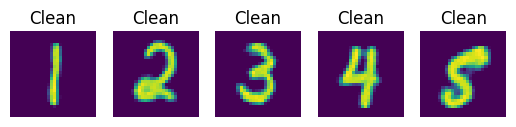

Epoch 40 -- Loss 0.007864383049309254


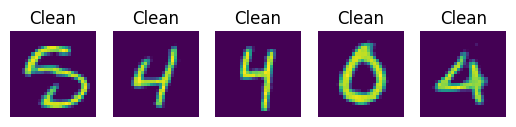

Epoch 50 -- Loss 0.0065474440343678


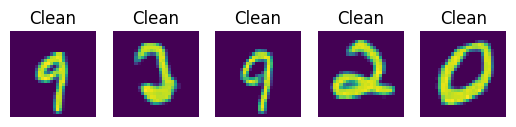

Epoch 60 -- Loss 0.006383707746863365


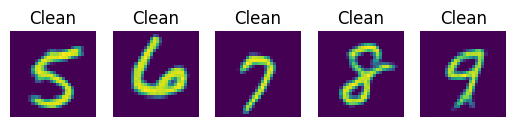

Epoch 70 -- Loss 0.005228527821600437


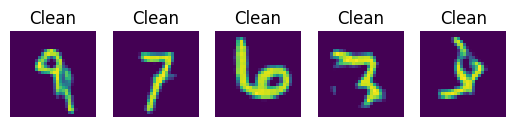

Epoch 80 -- Loss 0.00475623132660985


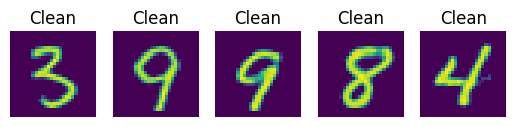

Epoch 90 -- Loss 0.004295133054256439


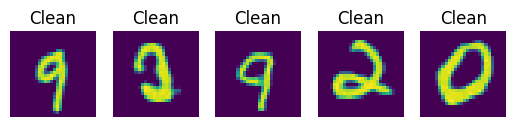

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import random
nb_epoch = 100
model = Unet().to(device)
loss_fct = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

predictions = model(random.choice(X_test_reshaped_noise).to(device))
predictions = predictions.cpu().detach().numpy()

for epoch in range(nb_epoch):
  for i in range(len(X_train_reshaped_noise)):
    optimizer.zero_grad()
    X = X_train_reshaped_noise[i].to(device)
    prediction = model(X)
    X_clean = X_train_reshaped_clean[i].to(device)
    loss = loss_fct(prediction, X_clean)
    loss.backward()
    optimizer.step()


  if epoch % 10 == 0:
    print(f"Epoch {epoch} -- Loss {loss}")

    predictions = model(random.choice(X_test_reshaped_noise).to(device))
    predictions = predictions.cpu().detach().numpy()

    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.imshow(predictions[i][0])
        plt.title("Clean")
        plt.axis('off')
    plt.show()


## Challenge: Denoising Dirty Documents/Remove noise from printed text

![Dirty Documents](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/image-hosting/TP3_Autoencodeur/denoisingdocument.JPG)

Lien vers le challenge: https://sharing.cs-campus.fr/compete/89